# Bibliotecas

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from scipy.io import mmread
from scipy import sparse as scs
import time
import sys
from T3 import (ProdutoVetorMatrizCOO, OrdenaCOO)

## Importando as matrizes baixadas

As matrizes são:
* 494_bus/494_bus.mtx -> *Algo estranho nessa aqui*
* bcsstm20/bcsstm20.mtx -> *Da para usar*
* bcsstk10/bcsstk10.mtx -> *Bateu*
* bcsstk05/bcsstk05.mtx -> *Bateu*
* mesh1em6/mesh1em6.mtx -> *Bateu*
* mesh1e1/mesh1e1.mtx -> *Bateu*
* mesh2e1/mesh2e1.mtx -> *Bateu*
* Trefethen_20/Trefethen_20.mtx -> *Bateu*
* Trefethen_700/Trefethen_700.mtx -> *Bateu, ótimo exemplo* 
* nos4/nos4.mtx -> *Bateu* 
* nasa1824/nasa1824.mtx -> *Bateu*
* ex33/ex33.mtx -> *Algo estranho aqui tambem* 

In [2]:
# Le o arquivo e ordena a representação COO da matriz esparsa por linha
sparse_matrix_coo = mmread("Trefethen_20/Trefethen_20.mtx")
# Gera a forma completa da matriz esparsa
matriz = sparse_matrix_coo.toarray()
# Gera um array de todas as posições "j" com elementos não nulos
rows, cols = OrdenaCOO(matriz)
# Vetor inicial
x = np.ones(len(matriz))

In [3]:
print("Não nulos:", len(rows))
print("Esparsidade: ", 1 - (len(rows) / (matriz.shape[0]*matriz.shape[1])))
print("Tamanho da matriz: ", len(matriz))

Não nulos: 158
Esparsidade:  0.605
Tamanho da matriz:  20


## Matrizes de teste

In [66]:
# Matriz de teste
matriz_teste = np.array([(4.,-1.,1.),(-1.,3.,-2.),(1.,-2.,3.)])
# Formato COO da matriz de teste
rows_teste, cols_teste = OrdenaCOO(matriz_teste)
# Vetor inicial
x_teste = np.array([1,0,0])

In [67]:
matriz_teste

array([[ 4., -1.,  1.],
       [-1.,  3., -2.],
       [ 1., -2.,  3.]])

In [5]:
# Matriz de teste
matriz_teste = np.array([(-4.,14.,0.),(-5.,13.,0.),(-1.,0.,2.)])
# Formato COO da matriz de teste
rows_teste, cols_teste = OrdenaCOO(matriz_teste)
# Vetor inicial
x_teste = np.array([1,1,1])

# Estimativa do raio espectral da matriz

## Método da potencia

Função de busca da norma infinita do vetor

In [19]:
def Busca(x):
    p = 0
    max = abs(x[p])
    for i in range(len(x)):
        if abs(x[i]) > max:
            p = i
    return p

Caracteristicas gerais

In [18]:
tol = 10**(-3)
max_it = 300

### Método da potencia simples

In [69]:
def MetodoDaPotencia(matriz, rows, cols, x, tol, max_it):
    k = 1
    x_aux = x.copy()
    p = Busca(x_aux)
    x_aux = x_aux / x_aux[p]
    while k <= max_it:
        y = ProdutoVetorMatrizCOO(matriz, rows, cols, x_aux)
        mu = y[p]
        p = Busca(y)
        if y[p] == 0:
            return (0, x_aux, k)
        ERR = max(x_aux - (y / y[p]))
        x_aux = y / y[p]
        print("ERR: ", ERR)
        if ERR < tol:
            return (mu, x_aux, k)
        k = k + 1
    return (mu, x_aux, k)

Aplicando na matriz do EP

In [16]:
# tempo_1_mp = time.time()
# mu_mp, x_mp, k_mp = MetodoDaPotencia(matriz, rows, cols, x, tol, max_it)
# tempo_2_mp = time.time()
# delta_mp = tempo_2_mp - tempo_1_mp
# print("delta: ", delta_mp)
# print("lambda: ", mu_mp)
# print("k: ", k_mp)

Aplicando na matriz de teste

In [70]:
MetodoDaPotencia(matriz_teste, rows_teste, cols_teste, x_teste, tol, max_it)

ERR:  0.25
ERR:  0.25
ERR:  0.19999999999999996
ERR:  0.1333333333333333
ERR:  0.07843137254901966
ERR:  0.04278074866310144
ERR:  0.02237762237762253
ERR:  0.011449016100178788
ERR:  0.005791331101257957
ERR:  0.002912599267299254
ERR:  0.0014605619740408748
ERR:  0.0007313502124770555


(5.997073170731708, array([ 1.        , -0.99926794,  0.99926794]), 12)

### Método da potência modificado

In [15]:
def MetodoDaPotenciaModificado(matriz, rows, cols, x, tol, max_it):
    k = 1
    mu_0 = 0
    mu_1 = 0
    x_aux = x.copy()
    p = Busca(x_aux)
    x_aux = x_aux / x_aux[p]
    while k <= max_it:
        y = ProdutoVetorMatrizCOO(matriz, rows, cols, x_aux)
        mu_2 = y[p]
        mu = mu_0 - ((mu_1 - mu_0) ** 2) / (mu_2 - 2*mu_1 + mu_0)
        p = Busca(y)
        if y[p] == 0:
            return (0, x_aux, k)
        ERR = max(x_aux - (y / y[p]))
        x_aux = y / y[p]
#         print(x_aux)
        if ERR < tol:
            return (mu, x_aux, k)
        k = k + 1
        mu_0 = mu_1
        mu_1 = mu_2
    return (mu, x_aux, k)

Aplicando na matriz do EP

In [14]:
# tempo_1_mpm = time.time()
# mu_mpm, x_mpm, k_mpm = MetodoDaPotenciaModificado(matriz, rows, cols, x, tol, max_it)
# tempo_2_mpm = time.time()
# delta_mpm = tempo_2_mpm - tempo_1_mpm
# print("delta: ", delta_mpm)
# print("lambda: ", mu_mpm)
# print("k: ", k_mpm)

Aplicando na matriz de teste

In [13]:
# MetodoDaPotenciaModificado(matriz_teste, rows_teste, cols_teste, x_teste, tol, max_it)

### Método da potência simétrico

In [71]:
def MetodoDaPotenciaSimetrico(matriz, rows, cols, x, tol, max_it):
    k = 1
    mu_0 = 0
    mu_1 = 0
    x_aux = x.copy()
    x_aux = x_aux / ((sum(x_aux**2))**(1/2))
    while k <= max_it:
        y = ProdutoVetorMatrizCOO(matriz, rows, cols, x_aux)
        mu_2 = x_aux.dot(y)
        mu = mu_0 - ((mu_1 - mu_0) ** 2) / (mu_2 - 2*mu_1 + mu_0)
        if (sum(y**2))**(1/2) == 0:
            return (0, x_aux, k)
        ERR_aux = (x_aux - (y / ((sum(y**2))**(1/2))))
        ERR = (sum(ERR_aux**2))**(1/2)
        x_aux = y / ((sum(y**2))**(1/2))
#         print("\ny: ", y)
#         print("x: ", x_aux)
        print("ERR: ", ERR)
        if ERR < tol:
            return (mu, x_aux, k)
        k = k + 1
        mu_0 = mu_1
        mu_1 = mu_2
    return (mu, x_aux, k)

Aplicando na matriz do EP

In [12]:
# tempo_1_mps = time.time()
# mu_mps, x_mps, k_mps = MetodoDaPotenciaSimetrico(matriz, rows, cols, x, tol, max_it)
# tempo_2_mps = time.time()
# delta_mps = tempo_2_mps - tempo_1_mps
# print("delta: ", delta_mps)
# print("lambda: ", mu_mps)
# print("k: ", k_mps)

Aplicando na matriz de teste

In [72]:
MetodoDaPotenciaSimetrico(matriz_teste, rows_teste, cols_teste, x_teste, tol, max_it)

ERR:  0.33820395745152554
ERR:  0.27477100047357156
ERR:  0.16468120466148475
ERR:  0.08678254753090772
ERR:  0.04399025963916114
ERR:  0.022071495780988264
ERR:  0.011045341364007763
ERR:  0.005523871366357542
ERR:  0.0027620858156711765
ERR:  0.0013810616758646933
ERR:  0.0006905331839818634


(6.000000000174623, array([ 0.57791395, -0.57706822,  0.57706822]), 11)

### Metodo da potência inversa

Considerações:
* Matrizes na forma COO

In [17]:
# def CalculaResultadoMatrizSuperior(matriz, b, n):
#     '''Recebe uma matriz triangular superior e um vetor 'b', e retorna o vetor 'x' do sistema Ax = b'''
#     x = np.array([0.0] * (n+1))
#     linha = n
#     if matriz[n][n] == 0: return None
#     x[n] = b[linha] / matriz[linha][linha]
#     linha -= 1
#     while 0 <= linha:
#         coef_aux = 0
#         linha_aux = linha + 1
#         while linha_aux <= n:
#             coef_aux += matriz[linha][linha_aux] * x[linha_aux]
#             linha_aux += 1
#         x[linha] = (b[linha] - coef_aux) / matriz[linha][linha]
#         linha -= 1
#     return x

In [18]:
# def CalculaResultadoMatrizInferior(matriz, b, n):
#     '''Recebe uma matriz triangular inferior e um vetor 'b', e retorna o vetor 'x' do sistema Ax = b'''
#     x = np.array([0.0] * (n+1))
#     linha = 0
#     if matriz[0][0] == 0: return None
#     x[0] = b[linha] / matriz[linha][linha]
#     linha =+ 1
#     while linha <= n:
#         coef_aux = 0
#         linha_aux = linha - 1
#         while 0 <= linha_aux:
#             coef_aux += matriz[linha][linha_aux] * x[linha_aux]
#             linha_aux -= 1
#         x[linha] = (b[linha] - coef_aux) / matriz[linha][linha]
#         linha += 1
#     return x

In [19]:
# def DecomposicaoLU(matriz, i):
#     '''Recebe uma matriz e realiza a decomposição LU da mesma, retornando as matrizes L, U e P, onde P é a matriz permutação'''
#     matriz_aux = matriz.copy()
#     L = np.identity(i)
#     P = np.identity(i)
#     p = 0
#     linha = 0
#     try:
#         while linha < (i-1):
#             if matriz_aux[p][linha] == 0:
#                 if p == i: return (None, None, None)
#                 p += 1
#                 continue
#             if p != linha:
#                 matriz_aux[(linha,p),:] = matriz_aux[(p,linha),:]
#                 P[(linha,p),:] = P[(p,linha),:]
#             linha_final = linha + 1
#             while linha_final < i:
#                 m = matriz_aux[linha_final][linha] / matriz_aux[linha][linha]
# #                 print("\nlinha: ", linha_final)
# #                 print("coluna: ", linha)
# #                 print(m)
#                 L[linha_final][linha] = m
# #                 print("matriz antes: \n", matriz_aux)
#                 matriz_aux[linha_final] = matriz_aux[linha_final] - m*matriz_aux[linha]
# #                 print("matriz depois: \n", matriz_aux)
#                 linha_final += 1
#             linha += 1
#             p = linha
#     except:
#         print("Erro no metodo sem pivotamento, na matriz de ordem: ", i, "\n")
#         return (None, None, None)
#     return (L, matriz_aux, P)

In [20]:
# L, U, P = DecomposicaoLU(matriz_teste, len(matriz_teste))
# print("\n", matriz_teste)
# print("\n", L)
# print("\n", U)
# print("\n", P)
# print("\n", (L.dot(U)))
# b = np.array([4,0,2], dtype=float)
# print("\nb = ", b)
# c = CalculaResultadoMatrizInferior(L, b, len(L)-1)
# print("vetor auxiliar: ",c)
# x = CalculaResultadoMatrizSuperior(U, c, len(U)-1)
# print("vetor x: ", x)

In [21]:
# def AproximacaoAutoValorDominante(matriz):
#     '''Aproxima o auto-valor dominante usando o circulo de Gersgorin'''
#     q = 0
#     limite_inferior = 0
#     limite_superior = 0
#     for i in range(len(matriz)):
#         somatoria = 0
#         for j in range(len(matriz[0])):
#             if j != i:
#                 somatoria += abs(matriz[i][j])
#             limite_inferior = matriz[i][i] - somatoria
#             limite_superior = somatoria + matriz[i][i]
#             if limite_superior > q: q = limite_superior
#     return q + 1

In [11]:
def AproximacaoAutoValorDominante(matriz, rows, cols):
    '''Aproxima o auto-valor dominante usando o circulo de Gersgorin, usando o formato COO da matriz'''
    q = 0
    limite_inferior = 0
    limite_superior = 0
    somatoria = 0
    a,i,j = (0,0,0)
    while i < len(rows):
        if rows[i] == j and rows[i] != cols[i]:
            somatoria += abs(matriz[rows[i]][cols[i]])
            i += 1
            continue
        if rows[i] == j and rows[i] == cols[i]:
            a = matriz[rows[i]][cols[i]]
            i += 1
            continue
        limite_inferior = a - somatoria
        limite_superior = somatoria + a
        if limite_superior > q: q = limite_superior
        j += 1
        somatoria = 0
    return q + 1

#### Norma infinito

In [10]:
def MetodoDaPotenciaInversaNormaInfinito(matriz, rows, cols, x, tol, max_it):
    mu_0 = 0
    mu_1 = 0
    n = len(matriz)
    x_aux = x.copy()
    matriz_aux = matriz.copy()
    # Usando o circulo de Gersgorin
    q = AproximacaoAutoValorDominante(matriz, rows, cols)
    k = 1
    p = Busca(x_aux)
    x_aux = x_aux / x_aux[p]
    B = (matriz_aux - q*np.identity(n))
    while k <= max_it:
        y = np.linalg.solve(B, x_aux)
        if np.array(y).any == None:
            return (mu, x_aux, k)
        mu_2 = y[p]
        mu = mu_0 - ((mu_1 - mu_0) ** 2) / (mu_2 - 2*mu_1 + mu_0)
        p = Busca(y)
        ERR = max(x_aux - (y/y[p]))
        x_aux = y / y[p]
        if ERR < tol:
            mu = (1/mu) + q
            return (mu, x_aux, k)
        k += 1
        mu_0 = mu_1
        mu_1 = mu_2
    return (mu, x_aux, k)

In [24]:
# def MetodoDaPotenciaInversaNormaInfinito2(matriz, rows, cols, x, tol, max_it):
#     mu_0 = 0
#     mu_1 = 0
#     n = len(matriz)
#     x_aux = x.copy()
#     matriz_aux = matriz.copy()
#     # Usando o circulo de Gersgorin
#     q = AproximacaoAutoValorDominante(matriz, rows, cols)
#     k = 1
#     p = Busca(x_aux)
#     x_aux = x_aux / x_aux[p]
#     B = (matriz_aux - q*np.identity(n))
#     L, U, P = DecomposicaoLU(B, len(B))
# #     print("\nL:\n ", L)
# #     print("\nU:\n ", U)
# #     print("\nP:\n ", P)
#     while k <= max_it:
# #         y = np.linalg.solve(B, x_aux)
#         c = CalculaResultadoMatrizInferior(L, x_aux, len(L)-1)
#         y = CalculaResultadoMatrizSuperior(U, c, len(U)-1)
#         if np.array(y).any == None:
#             return (mu, x_aux, k)
#         mu_2 = y[p]
#         mu = mu_0 - ((mu_1 - mu_0) ** 2) / (mu_2 - 2*mu_1 + mu_0)
#         p = Busca(y)
#         ERR = max(x_aux - (y/y[p]))
#         x_aux = y / y[p]
#         if ERR < tol:
#             mu = (1/mu) + q
#             return (mu, x_aux, k)
#         k += 1
#         mu_0 = mu_1
#         mu_1 = mu_2
#     return (mu, x_aux, k)

#### Norma 2

In [74]:
def MetodoDaPotenciaInversaNorma2(matriz, rows, cols, x, tol, max_it):
    mu_0 = 0
    mu_1 = 0
    n = len(matriz)
    x_aux = x.copy()
    matriz_aux = matriz.copy()
    k = 1
    # Usando o circulo de Gersgorin
    q = AproximacaoAutoValorDominante(matriz, rows, cols)
    x_aux = x_aux / ((sum(x_aux**2))**(1/2))
#     B = (matriz_aux - q*np.identity(n))
    B = scs.csr_matrix(matriz_aux - q*np.identity(n))
    while k <= max_it:
#         y = np.linalg.solve(B, x_aux)
        y = scs.linalg.spsolve(B,x_aux)
        if np.array(y).any == None:
            return (mu, x_aux, k)
        mu_2 = y.dot(x_aux)
        mu = mu_0 - ((mu_1 - mu_0) ** 2) / (mu_2 - 2*mu_1 + mu_0)
        ERR_aux = x_aux + (y / ((sum(y**2))**(1/2)))
        ERR = (sum(ERR_aux**2))**(1/2)
        x_aux = y / ((sum(y**2))**(1/2))
#         print("\ny: ", y)
#         print("x: ", x_aux)
        print("ERR: ", ERR)
        if ERR < tol:
            mu = (1/mu) + q
            return (mu, x_aux, k)
        k += 1
        mu_0 = mu_1
        mu_1 = mu_2
    return (mu, x_aux, k)

Aplicando na matriz do EP

In [8]:
# tempo_1_mpi = time.time()
# mu_mpi, x_mpi, k_mpi = MetodoDaPotenciaInversaNormaInfinito(matriz, rows, cols, x, tol, max_it)
# tempo_2_mpi = time.time()
# delta_mpi = tempo_2_mpi - tempo_1_mpi
# print("delta: ", delta_mpi)
# print("lambda: ", mu_mpi)
# print("k: ", k_mpi)

In [7]:
# tempo_1_mpi = time.time()
# mu_mpi_1, x_mpi_1, k_mpi_1 = MetodoDaPotenciaInversaNorma2(matriz, rows, cols, x, tol, max_it)
# tempo_2_mpi = time.time()
# delta_mpi_1 = tempo_2_mpi - tempo_1_mpi
# print("delta: ", delta_mpi_1)
# print("lambda: ", mu_mpi_1)
# print("k: ", k_mpi_1)

Aplicando na matriz de teste

In [28]:
# mu_mpi_3, x_mpi_3, k_mpi_3 = MetodoDaPotenciaInversaNormaInfinito(matriz_teste, rows_teste, cols_teste, x_teste, tol, max_it)
# print("\nlambda: ", mu_mpi_3)
# print("k: ", k_mpi_3)
# print("x: ", x_mpi_3)

In [75]:
mu_mpi_4, x_mpi_4, k_mpi_4 = MetodoDaPotenciaInversaNorma2(matriz_teste, rows_teste, cols_teste, x_teste, tol, max_it)

ERR:  0.6058108930553725
ERR:  0.25101395595390236
ERR:  0.06605373701832563
ERR:  0.016569086362377524
ERR:  0.004143145515973234
ERR:  0.0010358000383612186
ERR:  0.0002589502230221205


# Estimativa do espectro completo

In [6]:
def DecomposiçãoQR(matriz):
    T = matriz.copy()
    U = np.identity(len(matriz))
#     U = scs.identity(len(matriz))
    i = 0
    while i < 60:
        Q,R = np.linalg.qr(T)
#         Q = scs.csr_matrix(Q)
#         R = scs.csr_matrix(R)
#         T = R.dot(Q).toarray()
        T = R.dot(Q)
        U = U.dot(Q)
        i += 1
    return (T,U)

In [5]:
# time_1 = time.time()
# T, U = DecomposiçãoQR(matriz)
# time_2 = time.time()
# print("delta:", time_2 - time_1)

In [4]:
# raio_espectral = 0
# for i in range(len(T)):
#     if abs(T[i][i]) > raio_espectral:
#         raio_espectral = T[i][i]
#     print("auto-valor", i, ":", T[i][i])
# print("\nRaio espectral: ", raio_espectral)

# Gerando o DataFrame e os gráficos

In [3]:
# matrizes = ["bcsstm20/bcsstm20.mtx", "bcsstk10/bcsstk10.mtx", "bcsstk05/bcsstk05.mtx", "mesh1em6/mesh1em6.mtx",
#             "mesh1e1/mesh1e1.mtx", "mesh2e1/mesh2e1.mtx", "Trefethen_20/Trefethen_20.mtx", "Trefethen_700/Trefethen_700.mtx",
#             "nos4/nos4.mtx", "nasa1824/nasa1824.mtx"]
# nao_nulos = []
# esparsidade = []
# tamanho = []
# tempos_mps = []
# tempos_mpi = []
# tempos_qr = []
# inter_mps = []
# inter_mpi = []
# raio_esp_mps = []
# raio_esp_mpi = []
# raio_esp_qr = []
# menor_autoValor_qr = []
# for nome_matriz in matrizes:
#     # Le o arquivo e ordena a representação COO da matriz esparsa por linha
#     sparse_matrix_coo = mmread("./" + nome_matriz)
#     # Gera a forma completa da matriz esparsa
#     matriz = sparse_matrix_coo.toarray()
#     # Gera um array de todas as posições "j" com elementos não nulos
#     rows, cols = OrdenaCOO(matriz)
#     # Vetor inicial
#     x = np.ones(len(matriz))
#     print("\nmatriz: ", nome_matriz)
#     print("Não nulos:", len(rows))
#     print("Esparsidade: ", 1 - (len(rows) / (matriz.shape[0]*matriz.shape[1])))
#     print("Tamanho da matriz: ", len(matriz))
#     nao_nulos.append(len(rows))
#     esparsidade.append(1 - (len(rows) / (matriz.shape[0]*matriz.shape[1])))
#     tamanho.append(len(matriz))
#     # Configurações
#     tol = 10**(-3)
#     max_it = 300
#     # Aplicando o metodo da potência simétrico
#     tempo_1_mps = time.time()
#     mu_mps, x_mps, k_mps = MetodoDaPotenciaSimetrico(matriz, rows, cols, x, tol, max_it)
#     tempo_2_mps = time.time()
#     delta_mps = tempo_2_mps - tempo_1_mps
#     tempos_mps.append(delta_mps)
#     inter_mps.append(k_mps)
#     raio_esp_mps.append(mu_mps)
#     # Metodo da potencia inversa
#     tempo_1_mpi = time.time()
#     mu_mpi, x_mpi, k_mpi = MetodoDaPotenciaInversaNorma2(matriz, rows, cols, x, tol, max_it)
#     tempo_2_mpi = time.time()
#     delta_mpi = tempo_2_mpi - tempo_1_mpi
#     tempos_mpi.append(delta_mpi)
#     inter_mpi.append(k_mpi)
#     raio_esp_mpi.append(mu_mpi)
#     # Decomposicao QR para encontrar o espectro completo
#     tempo_1_qr = time.time()
#     T, U = DecomposiçãoQR(matriz)
#     tempo_2_qr = time.time()
#     delta_qr = tempo_2_qr - tempo_1_qr
#     # Encontrando o maior e o menor auto-valor
#     raio_espectral = 0
#     menor_auto_valor = T[0][0]
#     for i in range(len(T)):
#         if abs(T[i][i]) > raio_espectral:
#             raio_espectral = T[i][i]
#         if abs(T[i][i]) < menor_auto_valor:
#             menor_auto_valor = T[i][i]
#     tempos_qr.append(delta_qr)
#     raio_esp_qr.append(raio_espectral)
#     menor_autoValor_qr.append(menor_auto_valor)
#     print("\nRaio espectral: ", raio_espectral)
#     print("Menor auto-valor: ", raio_espectral)
# df = pd.DataFrame({"matrizes": matrizes, "dimensao": tamanho, "nao_nulos": nao_nulos, "esparsidade": esparsidade,
#                     "tempos_metPotSim": tempos_mps, "interacoes_metPotSim": inter_mps, "raio_esp_metPotSim": raio_esp_mps, 
#                     "tempos_metPotInv": tempos_mpi, "interacoes_metPotInv": inter_mpi, "raio_esp_metPotInv": raio_esp_mpi,
#                     "tempos_QR": tempos_qr, "raio_esp_QR": raio_esp_qr, "menor_autoValor_QR": menor_autoValor_qr})
# df.to_csv("analise_resultados.csv")

In [46]:
df = pd.read_csv("analise_resultados.csv", index_col=0)

In [65]:
df

,matrizes,dimensao,nao_nulos,esparsidade,tempos_metPotSim,interacoes_metPotSim,raio_esp_metPotSim,tempos_metPotInv,interacoes_metPotInv,raio_esp_metPotInv,tempos_QR,raio_esp_QR,menor_autoValor_QR,erro_metPotSim,erro_metPotInv
6,Trefethen_20/Trefethen_20.mtx,20,158,0.605000,0.093601,61,7.151243e+01,0.003727,7,7.151243e+01,0.010169,7.147996e+01,1.133524,0.032473,0.032473
3,mesh1em6/mesh1em6.mtx,48,306,0.867188,0.036452,33,7.205989e+00,0.013289,22,7.205989e+00,0.023155,7.203349e+00,1.179959,0.002640,0.002640
4,mesh1e1/mesh1e1.mtx,48,306,0.867188,0.043843,75,9.134157e+00,0.007684,27,9.134158e+00,0.010475,9.101201e+00,1.740094,0.032956,0.032957
8,nos4/nos4.mtx,100,594,0.940600,0.124050,86,8.491369e-01,0.039376,108,8.491364e-01,0.116445,8.450233e-01,0.000538,0.004114,0.004113
2,bcsstk05/bcsstk05.mtx,153,2423,0.896493,0.165879,45,6.197273e+06,0.020349,25,6.197285e+06,0.179633,6.197286e+06,437.612658,-13.521296,-1.388083
5,mesh2e1/mesh2e1.mtx,306,2018,0.978448,0.038594,16,3.813006e+02,0.025919,10,3.813006e+02,1.062819,3.813006e+02,1.326681,-0.000006,-0.000002
0,bcsstm20/bcsstm20.mtx,485,485,0.997938,0.282801,279,4.779572e+07,0.007532,2,4.785387e+07,2.131537,4.779555e+07,187.154177,164.810496,58321.295274
7,Trefethen_700/Trefethen_700.mtx,700,12654,0.974176,13.417531,301,5.278101e+03,1.132110,10,5.279287e+03,6.101471,5.275885e+03,1.120774,2.216547,3.402458
1,bcsstk10/bcsstk10.mtx,1086,22070,0.981287,3.004631,123,4.474293e+07,0.391634,53,4.474306e+07,19.543896,4.424715e+07,85.412274,495782.226277,495909.016469
9,nasa1824/nasa1824.mtx,1824,39208,0.988215,3.665092,84,2.121717e+07,2.521035,53,2.121717e+07,87.496205,2.121717e+07,11.190579,5.969403,5.792322


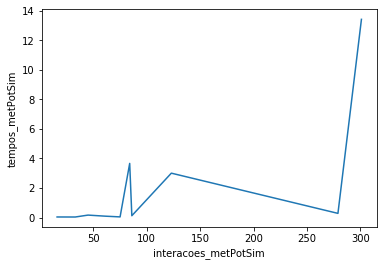

In [58]:
sns.lineplot(x="interacoes_metPotSim",y="tempos_metPotSim", data=df)

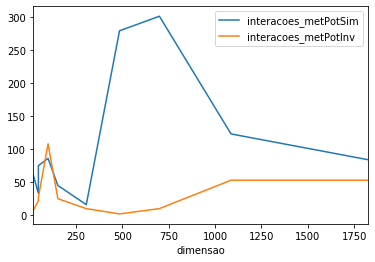

In [62]:
df.plot(x="dimensao",y=["interacoes_metPotSim","interacoes_metPotInv"])

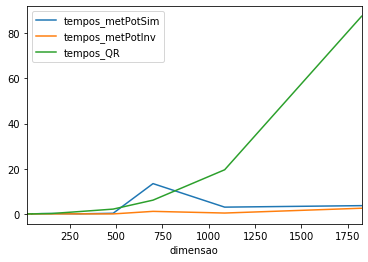

In [63]:
df.plot(x="dimensao",y=["tempos_metPotSim","tempos_metPotInv","tempos_QR"])